In [1]:
import zipfile,os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
from torchmetrics import StructuralSimilarityIndexMeasure
from skimage.color import rgb2lab, lab2rgb
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.functional import structural_similarity_index_measure
from scipy.linalg import sqrtm
import math
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
import os
import shutil
#from google.colab import files
from torchmetrics import PeakSignalNoiseRatio
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import csv


# <center> **Table of contents** <a class="anchor" id="0"></a>
1. Introduction <br>
2. Dataset <br>
    2.1 Description <br>
    2.2 Setting up the device <br>
    2.3 Preparing Colab to Kaggle installation and downloading the dataset
<br>
    2.4 Creating paths for  datasets <br>
    2.5 Displaying sample dataset <br>
    2.6 Making dataset and dataloader <br>
3. Implementing U-NET Autoencoder <br>
    3.1 Building the Generator <br>
    3.2 Building PatchGAN - Discriminator <br>
4. GAN Loss <br>
    4.1 Creating GAN-Loss Class with the options GAN and Wgan <br>
    4.2 Model Inizialitation <br>
    4.3 Assembling the model <br>
5. Quality Measurement<br>
    5.1 Creating FID Function <br>
    5.2 Creating Inception Score Function <br>
    5.3 PSNR and SSIM measurement <br>
6. Training and Test<br>
    6.1 Training function <br>
    6.2 Test function <br>
7. WGAN Loss <br>
    7.1 Setting up the WGAN loss <br>
    7.2 Model Inizialitation WGAN <br>
    7.3 Assembling WGAN <br>








## **1. Introduction**

* In recent years, studies on the utilizations of deep learning in computer vision and image processing have been increasing visibly. In these studies, One of the most efficient methods employed in these studies is the "image-to-image translation" approach. In this method, provided with an input image to the model and it is expected to produce an output from this image in line with the requests. One of the most common applications of this method is the colourisation of grayscale (black-white) images.

* In our project, we aim to transform black and white images into color. To achieve this, we utilized deep learning models, specifically Generative Adversarial Networks (GAN) and its variant, Wasserstein-GAN (WGAN). These models learn from the provided images to generate new and unique visuals. GAN consists of two parts: the generator, which produces new images, and the discriminator, which compares the generated images against the real ones to produce a result. Our GANs's generator is supported by U-net for efficient and accurate image segmentation and use PatchGAN discriminator as discriminator to be able to evaluate the input images in more detail

## **2. Dataset**

**Source of the Dataset:**https://cocodataset.org/#download


**References:**

* *Main Paper:* https://arxiv.org/abs/1611.07004
* *Main Code Example:* https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8
* *Code Example:* https://medium.com/analytics-vidhya/image-to-image-translation-gan-and-conditional-gan-f995901de39


**2.2 Setting up the device**

In [2]:
#!ls /content/gdrive/MyDrive

In [3]:
# Check if a cuda GPU is available
if torch.cuda.is_available():
    print('GPU available')
    # Define the device (here you can select which GPU to use if more than 1)
    device = torch.device("cuda")
else:
    print('GPU not available')

GPU available


**2.3 Preparing Colab to Kaggle installation and downloading the dataset**


In [4]:
"""
! pip3 install tqdm
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ifigotin/imagenetmini-1000
"""

'\n! pip3 install tqdm\n! pip install kaggle\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n! kaggle datasets download -d ifigotin/imagenetmini-1000\n'

In [5]:
"""
# Download Dataset from Drive
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

#train set
coco_url = "https://drive.google.com/uc?export=download&id=1-Fhr2soyaDORAgrhkSfyrEBveH3XAOh9"
imagenet_url = "https://drive.google.com/uc?export=download&id=15DllY92zEHRHeTTY_CoXOiHHedFgYCot"
output_i = "imagenetmini-1000.zip"
output_c = "coco_val2017.zip"
gdown.download(coco_url, output_c)
"""

'\n# Download Dataset from Drive\n!pip install -U --no-cache-dir gdown --pre\n!pip install --upgrade gdown\nimport gdown\n\n#train set\ncoco_url = "https://drive.google.com/uc?export=download&id=1-Fhr2soyaDORAgrhkSfyrEBveH3XAOh9"\nimagenet_url = "https://drive.google.com/uc?export=download&id=15DllY92zEHRHeTTY_CoXOiHHedFgYCot"\noutput_i = "imagenetmini-1000.zip"\noutput_c = "coco_val2017.zip"\ngdown.download(coco_url, output_c)\n'

**2.4 Creating paths for  datasets**

In [6]:
"""

local_zip = './coco_val2017.zip'
#'/content/imagenetmini-1000.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("./coco")
#('/content/imagenet')
zip_ref.close()
"""

'\n\nlocal_zip = \'./coco_val2017.zip\'\n#\'/content/imagenetmini-1000.zip\'\nzip_ref = zipfile.ZipFile(local_zip, \'r\')\nzip_ref.extractall("./coco")\n#(\'/content/imagenet\')\nzip_ref.close()\n'

In [7]:
# Defining the path for the dataset location
paths = []
img_path = './coco/val2017'
# '/content/imagenet/imagenet-mini'

# Get all the paths of the images in the directory
all_paths = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) in os.walk(img_path) for f in filenames if f.endswith('.jpg')]

# Set the seed for reproducibility
np.random.seed(123)

# Randomly select 12,000 images from the paths
paths_subset = np.random.choice(all_paths, 5_000, replace=False)

# Shuffle the paths
np.random.shuffle(paths_subset)

# Split the paths into train, validation and test sets
train_paths = paths_subset[:4000]
test_paths = paths_subset[4000:]

# Print the length of each set
print(len(train_paths), len(test_paths))


4000 1000


**2.5 Displaying sample of dataset**

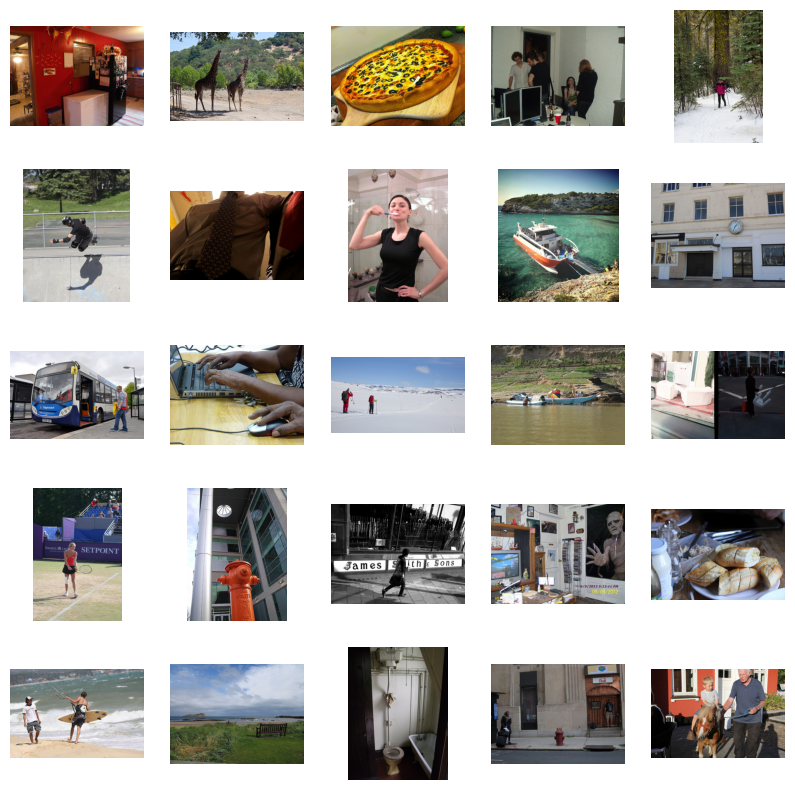

In [8]:
# Displaying some example images in size of 10x10
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [9]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train', SIZE=256):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'test':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

In [10]:
def make_dataloaders(batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [11]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(batch_size=10,  paths=test_paths, split='test')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
250 100


## **3. Implementing U-NET Autoencoder**

**3.1 Building the Generator**

In [12]:
class Unet(nn.Module):

    def __init__(self, in_nc, out_nc, num_filter=64, use_dropout=False):
        super(Unet, self).__init__()
        Norm2d=nn.BatchNorm2d
        # construct unet structure
        # add the innermost block
        unet_block = Skip_Connections(num_filter * 8, num_filter * 8, norm_layer=Norm2d, innermost=True)
        #print(unet_block)

        # add intermediate block with nf * 8 filters
        unet_block = Skip_Connections(num_filter * 8, num_filter * 8,  submodule=unet_block, norm_layer=Norm2d, use_dropout=False)
        unet_block = Skip_Connections(num_filter * 8, num_filter * 8,  submodule=unet_block, norm_layer=Norm2d, use_dropout=False)
        unet_block = Skip_Connections(num_filter * 8, num_filter * 8,  submodule=unet_block, norm_layer=Norm2d, use_dropout=False)

        # gradually reduce the number of filters from nf * 8 to nf.
        unet_block = Skip_Connections(num_filter * 4, num_filter * 8,  submodule=unet_block, norm_layer=Norm2d)
        unet_block = Skip_Connections(num_filter * 2, num_filter * 4,  submodule=unet_block, norm_layer=Norm2d)
        unet_block = Skip_Connections(num_filter, num_filter * 2,  submodule=unet_block, norm_layer=Norm2d)

        # add the outermost block
        self.model = Skip_Connections(out_nc, num_filter, in_nc=in_nc, submodule=unet_block, outermost=True, norm_layer=Norm2d)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

class Skip_Connections(nn.Module):
    def __init__(self, outer_nc, inner_nc, in_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(Skip_Connections, self).__init__()
        self.outermost = outermost
        if in_nc is None:
            in_nc = outer_nc
        downconv = nn.Conv2d(in_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [13]:
#To see the shape output - expecting 2 in channels
generator = Unet(1, 2, 64, use_dropout=False)
dummy_input = torch.randn(10, 1, 256, 256) # batch_size, channels, size, size
out = generator(dummy_input)
out.shape

torch.Size([10, 2, 256, 256])

**3.2 Building PatchGAN - Discriminator**

In [14]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        for i in range(n_down): # Make sure to not use normalization or activation for the last layer of the model
            # check if current iteration is the last iteration
            s = 1 if i == (n_down-1) else 2  # the 'if' statement is taking care of not using
            model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=s)]

        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]

        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [15]:
print(PatchDiscriminator(input_c=3))

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [16]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(10, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([10, 1, 30, 30])

## **4. GAN Loss**

**4.1 Creating GAN-Loss Class with the options GAN and Wgan**

In [17]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == "wgan":
            print("wgan selected as gan mode")
            self.loss = None
#        elif gan_mode == "cwgan":
#            print("wgan selected as cwgan mode")
#            self.loss = None


    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):

      if self.gan_mode == "wgan":
            if target_is_real:
                loss = -preds.mean()
            else:
                loss = preds.mean()

 #     elif self.gan_mode == "cwgan":
 #           if target_is_real:
 #               loss = -preds.mean()
 #           else:
 #              loss = preds.mean()

      elif self.gan_mode == "vanilla":
          labels = self.get_labels(preds, target_is_real)
          loss = self.loss(preds, labels)

      return loss

**4.2 Model Inizialitation**

In [18]:
def init_model(model, device,init="norm",gain=0.02):

    model = model.to(device)
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if init == 'norm':
                nn.init.normal_(m.weight, mean=0.0, std=gain)
    print(f"model initialized with {init} initialization")
    return model


**4.3 Assembling the model**

In [19]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(1, 2, 64, use_dropout=False).cuda().float(), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))


    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## **5. Quality Measurement**

**5.1 Creating FID Function**

In [20]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    if isinstance(images, torch.Tensor):
        if images.device.type == 'cuda':
            images = images.cpu()
        images = images.numpy()
    return np.array([resize(image, new_shape, 0) for image in images])

def calculate_fid(real_embeddings, generated_embeddings):
    # prepare the inception v3 model
    model_incv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

    # resize and pre-process images
    real_embeddings = preprocess_input(scale_images(real_embeddings, (299,299,3)))
    generated_embeddings = preprocess_input(scale_images(generated_embeddings, (299,299,3)))

    # calculate activations
    real_embeddings = model_incv3.predict(real_embeddings)
    generated_embeddings = model_incv3.predict(generated_embeddings)

    # calculate mean and covariance statistics
    mu1, sigma1 = np.mean(real_embeddings, axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = np.mean(generated_embeddings, axis=0), np.cov(generated_embeddings,  rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


**5.2 Creating Inception Score Function**

In [21]:
def inception_score(imgs, cuda=True, batch_size=8, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)
    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)
    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

**5.3 Loss meters- Implementing the quality measurements**

In [22]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

import torch
from skimage.color import lab2rgb

def lab_to_rgb(L, ab):
    """
    Takes a batch of images which are L and ab images and converts them to RGB
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()

    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(torch.from_numpy(img_rgb))

    return torch.stack(rgb_imgs, dim=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

    print(type(fake_imgs))
    print(fake_imgs.shape)
    fake_imgs = fake_imgs.permute(0,3,1,2 )
    real_imgs = real_imgs.permute(0,3,1,2 )

    print(fake_imgs.shape)
    print(real_imgs.shape)

    #calculate fid
    fid = calculate_fid(real_imgs, fake_imgs)
    print('FID: %.3f' % fid)

    #calculate ssim
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_score = ssim(fake_imgs,real_imgs)
    print("ssim",ssim_score)

    #pnsr
    psnr = PeakSignalNoiseRatio()
    pnsr_score = psnr(real_imgs, fake_imgs)
    print("pnsr",pnsr_score)

    #calculate inception score (IS)
    inception = inception_score(fake_imgs, resize=True)
    print("\ninception: %.3f" % inception[0])

    return fid, ssim_score, pnsr_score, inception


def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

## **6. Training and Test**

**6.1 Training Function**

In [23]:
def train_model_Normal(model, train_dl, epochs, display_every=250):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals

    loss_meter_dict = create_loss_meters() # function returning a dictionary of objects to log the losses of the complete network

    # Save the loss names and metric names as the header row of the losses.csv file
    loss_names = list(loss_meter_dict.keys())

    # Open the losses.csv file in append mode
    losses_csv_file = 'COCO_Dataset_Results\saved_model_colorization/GAN/Values/losses.csv'
    with open(losses_csv_file, 'a', newline='') as losses_file:
        losses_writer = csv.writer(losses_file)

        # Write the header row only if it's a new file
        if losses_file.tell() == 0:
            losses_writer.writerow(['Epoch'] + loss_names)

        # Open the results.csv file in append mode
        results_csv_file = 'COCO_Dataset_Results\saved_model_colorization/GAN/Values/results.csv'
        with open(results_csv_file, 'a', newline='') as results_file:
            results_writer = csv.writer(results_file)

            # Write the header row only if it's a new file
            if results_file.tell() == 0:
                results_writer.writerow(['Epoch', 'fid', 'ssim_score', 'pnsr_score', 'inception_score'])

            for e in range(epochs):
                i = 0
                for data in tqdm(train_dl):
                    model.setup_input(data)
                    model.optimize()
                    update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
                    i += 1

                    if i % display_every == 0:
                        print(f"\nEpoch {e+1}/{epochs}")
                        print(f"Iteration {i}/{len(train_dl)}")

                        log_results(loss_meter_dict) # function to print out the losses
                        fid, ssim_score, pnsr_score, inception_score = visualize(model, data, save=False)

                        # Convert ssim_score and inception_score to appropriate values
                        ssim_score = ssim_score.item()
                        inception_score = inception_score[0].item()
                        pnsr_score = pnsr_score.item()

                        # Extract loss values from AverageMeter objects
                        loss_values = [loss_meter_dict[loss_name].avg for loss_name in loss_names]


                        # Write the evaluation metric values to the results.csv file
                        results_writer.writerow([e+1, fid, ssim_score, pnsr_score, inception_score])

                        # Write the loss values to the losses.csv file
                        losses_writer.writerow([e+1] + loss_values)

                if e % 20 == 0:
                    model_path = os.path.join('COCO_Dataset_Results\saved_model_colorization/GAN/models/model_normal_{}.pt'.format(e))
                    torch.save({
                        'modelA_state_dict': model.net_G.state_dict(),
                        'modelB_state_dict': model.net_D.state_dict(),
                        'optimizerA_state_dict': model.opt_G.state_dict(),
                        'optimizerB_state_dict': model.opt_D.state_dict(),
                    }, model_path)


In [24]:
"How to load the model from Google Drive\
Make sure you have mounted your Google Drive.\
Now, we will access our saved model checkpoint from the Google Drive and use\
it. We know the path and we will use that in torch.load :"

#model_save_name = 'classifier.pt'
#path = F'/content/gdrive/My Drive/{model_save_name}'
#model.load_state_dict(torch.load(path))

'How to load the model from Google DriveMake sure you have mounted your Google Drive.Now, we will access our saved model checkpoint from the Google Drive and useit. We know the path and we will use that in torch.load :'

Important: In order to presave the models beucase of the Google Colab limit, let's to download the model.

model initialized with norm initialization
model initialized with norm initialization
Iteration 100/100


C:\Users\QP\AppData\Local\Temp\ipykernel_18964\4291523846.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


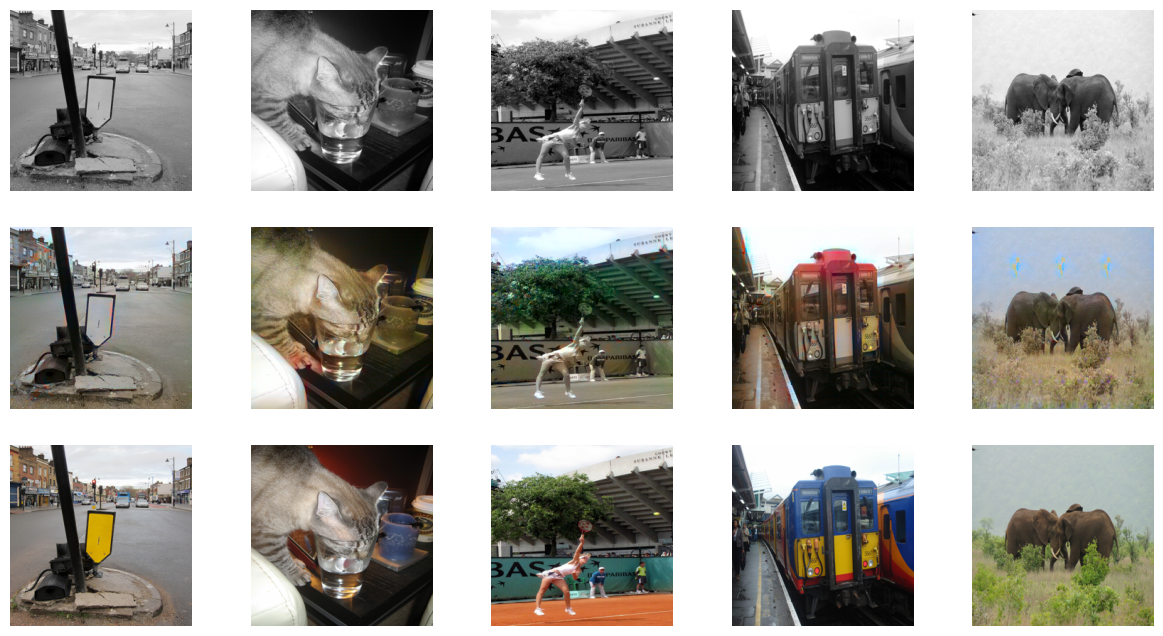

<class 'torch.Tensor'>
torch.Size([10, 256, 256, 3])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
1/1 [==============================] - 0s 262ms/step
FID: 0.060
ssim tensor(0.8373, device='cuda:0')
pnsr tensor(19.9734)


C:\Users\QP\.conda\envs\NNDL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\QP\.conda\envs\NNDL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\QP\AppData\Local\Temp\ipykernel_18964\1718581595.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()



inception: 5.900


In [26]:


# load the saved model and optimizer state
model = MainModel()

checkpoint = torch.load("COCO_Dataset_Results\saved_model_colorization\GAN\Models\model_normal_80.pt")

model.net_G.load_state_dict(checkpoint['modelA_state_dict'])
model.net_D.load_state_dict(checkpoint['modelB_state_dict'])
model.opt_G.load_state_dict(checkpoint['optimizerA_state_dict'])
model.opt_D.load_state_dict(checkpoint['optimizerB_state_dict'])

# continue training the model
#Note that you will need to specify the number of epochs you want to train for in the epochs variable.
#If you want to train for an additional 10 epochs, for example, you can set epochs = 10.

test_model(model, val_dl)
#train_model_Normal(model, test_dl, 21)



In [ ]:
model = MainModel()
train_model_Normal(model, train_dl, 100)

**6.2 Test Function**

In [25]:
def test_model(model, test_dl):
    model.eval() # set model to eval mode
    i = 0
    # iterate through the test data set
    for data in test_dl:
        model.setup_input(data) # set up input data for the model
        model.forward() # make predictions using the model
        i += 1
    # print out the losses and visualize the model's outputs
    print(f"Iteration {i}/{len(test_dl)}")
    visualize(model, data, save=True)

In [ ]:
test_model(model, test_dl)

## **7. W-GAN Model**

**7.1 Assembling WGAN**

In [27]:
class WGan(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(1, 2, 64, use_dropout=False).cuda().float(), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='wgan').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = torch.optim.RMSprop(self.net_G.parameters(), lr=0.00005)
        self.opt_D = torch.optim.RMSprop(self.net_D.parameters(), lr=0.00005)


    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

**7.2 Training WGAN**


In [28]:
def train_model_W(model, train_dl, epochs, display_every=250):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals

    loss_meter_dict = create_loss_meters() # function returning a dictionary of objects to log the losses of the complete network

    # Save the loss names and metric names as the header row of the losses.csv file
    loss_names = list(loss_meter_dict.keys())

    # Open the losses.csv file in append mode
    losses_csv_file = 'saved_model_colorization/WGAN/Values/losses.csv'
    with open(losses_csv_file, 'a', newline='') as losses_file:
        losses_writer = csv.writer(losses_file)

        # Write the header row only if it's a new file
        if losses_file.tell() == 0:
            losses_writer.writerow(['Epoch'] + loss_names)

        # Open the results.csv file in append mode
        results_csv_file = 'saved_model_colorization/WGAN/Values/results.csv'
        with open(results_csv_file, 'a', newline='') as results_file:
            results_writer = csv.writer(results_file)

            # Write the header row only if it's a new file
            if results_file.tell() == 0:
                results_writer.writerow(['Epoch', 'fid', 'ssim_score', 'pnsr_score', 'inception_score'])

            for e in range(epochs):
                i = 0
                for data in tqdm(train_dl):
                    model.setup_input(data)
                    model.optimize()
                    update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
                    i += 1

                    if i % display_every == 0:
                        print(f"\nEpoch {e+1}/{epochs}")
                        print(f"Iteration {i}/{len(train_dl)}")

                        log_results(loss_meter_dict) # function to print out the losses
                        fid, ssim_score, pnsr_score, inception_score = visualize(model, data, save=False)

                        # Convert ssim_score and inception_score to appropriate values
                        ssim_score = ssim_score.item()
                        inception_score = inception_score[0].item()
                        pnsr_score = pnsr_score.item()

                        # Extract loss values from AverageMeter objects
                        loss_values = [loss_meter_dict[loss_name].avg for loss_name in loss_names]


                        # Write the evaluation metric values to the results.csv file
                        results_writer.writerow([e+1, fid, ssim_score, pnsr_score, inception_score])

                        # Write the loss values to the losses.csv file
                        losses_writer.writerow([e+1] + loss_values)

                if e % 20 == 0:
                    model_path = os.path.join('saved_model_colorization/WGAN/models/model_W_{}.pt'.format(e))
                    torch.save({
                        'modelA_state_dict': model.net_G.state_dict(),
                        'modelB_state_dict': model.net_D.state_dict(),
                        'optimizerA_state_dict': model.opt_G.state_dict(),
                        'optimizerB_state_dict': model.opt_D.state_dict(),
                    }, model_path)


model initialized with norm initialization
model initialized with norm initialization
wgan selected as gan mode
Iteration 100/100


C:\Users\QP\AppData\Local\Temp\ipykernel_18964\4291523846.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


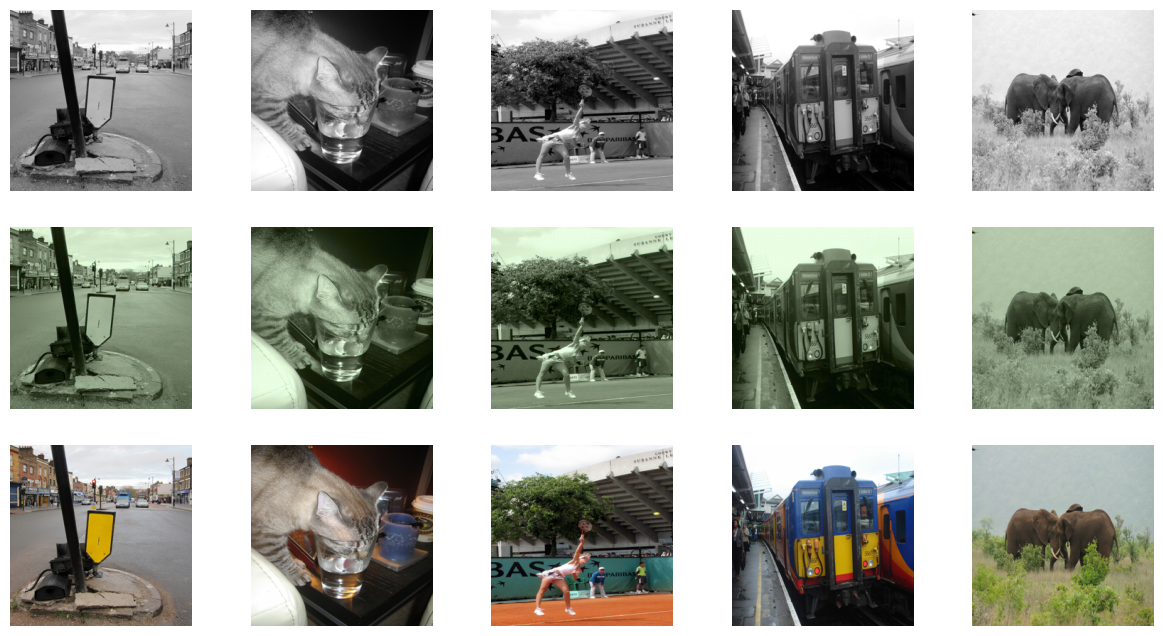

<class 'torch.Tensor'>
torch.Size([10, 256, 256, 3])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
1/1 [==============================] - 0s 296ms/step
FID: 0.094
ssim tensor(0.7593, device='cuda:0')
pnsr tensor(18.6328)


C:\Users\QP\AppData\Local\Temp\ipykernel_18964\1718581595.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()



inception: 5.567


In [30]:


# load the saved model and optimizer state
model_W = WGan()

checkpoint = torch.load("COCO_Dataset_Results\saved_model_colorization\WGAN\Models\model_W_100.pt")

model.net_G.load_state_dict(checkpoint['modelA_state_dict'])
model.net_D.load_state_dict(checkpoint['modelB_state_dict'])
model.opt_G.load_state_dict(checkpoint['optimizerA_state_dict'])
model.opt_D.load_state_dict(checkpoint['optimizerB_state_dict'])

# continue training the model
#Note that you will need to specify the number of epochs you want to train for in the epochs variable.
#If you want to train for an additional 10 epochs, for example, you can set epochs = 10.

test_model(model_W, val_dl)
#train_model_w(model, train_dl, 1)




In [ ]:
model_W =WGan()
train_model_W(model_W, train_dl, 100)

**7.3 Test WGAN**

In [ ]:
test_model(model_W, train_dl)

Important: To get the loss values for each epoch Values

In [ ]:
import pandas as pd

"""
W_loss= pd.read_csv('saved_model_colorization/WGAN/Values/losses.csv')
print(W_loss)"""

W_results= pd.read_csv("COCO_Dataset_Results\saved_model_colorization/WGAN/Values/results.csv")
print(W_results)

"""print(pd.read_csv('saved_model_colorization/GAN/Values/losses.csv'))

print(pd.read_csv('saved_model_colorization/GAN/Values/results.csv'))"""